In [422]:
import torch
import pyro
from pyro.distributions import *
#from collections import Counter
import pyro.infer
import pyro.optim
pyro.enable_validation(True)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

import random

import numpy as np
import pandas as pd
import scipy.stats as stats

import utils

In [4]:
# set a random seed
random.seed(1625)

# fix the range of pitches we consider
fifth_range = 2*7 # 2 diatonics
npcs = 2*fifth_range+1 # around C: Cbb to C## on LoF
utils.set_fifth_range(fifth_range)

# A Cognitive Model or Harmonic Types

## Model

A chord consists of a number of notes,
which are either generated as stable chord tones or as ornaments.
We model this process by distinguishing (for each chord type)
a distribution of chord tones and a distribution of ornaments.
For each generated note, a coin is flipped as to whether the tone is generated as a chord tone or ornament.
The pitch is then drawn from the corresponding distribution.
Since we don't always know the type of a note, we flip another coin to decide whether the type is observed or not (in which case `unknown` is emitted for both ornaments and chordtones).

Priors:
- choose $\vec\chi \sim \text{Dirichlet}(0.5, n_\text{harmonies})$
- choose $\theta \sim \text{Beta}(1,1)$
- choose $\lambda \sim \text{Gamma}(3,1)$
- for each chord type $i$
  - choose $\vec\phi_{ct}^{(i)} \sim \text{Dirichlet}(0.5, n_\text{pitches})$
  - choose $\vec\phi_{or}^{(i)} \sim \text{Dirichlet}(0.5, n_\text{pitches})$

Generating a single chord (long version):
- choose $h \sim \text{Categorical}(\vec\chi)$
- choose $n \sim \text{Poisson}(\lambda) + 1$
- for each note $i \in 1, \ldots, n$:
  - choose $t_i \sim \text{Bernoulli}(\theta)$
  - choose $p_i \sim \begin{cases}
                       \text{Categorical}(\vec\phi_{ct}^{(h)}) & \text{if } t_i = 1\\
                       \text{Categorical}(\vec\phi_{or}^{(h)}) & \text{if } t_i = 0
                     \end{cases}$
  - choose $o_i \sim \text{Bernoulli}(p_\text{obs})$
  - choose $ot_i = \begin{cases}
                     \text{'chordtone'} & \text{if } o_i = 1 \wedge p_i = 1\\
                     \text{'ornament'} & \text{if } o_i = 1 \wedge p_i = 0\\
                     \text{'unknown'} & \text{if } o_i = 0\\
                   \end{cases}$
- count $(p_i,ot_i)$ pairs

Generating a single chord (compact version)
- choose $h \sim \text{Catecorical}(\vec\chi)$
- choose $n \sim \text{Poisson}(\lambda) + 1$
- choose $n_{p,ot} \sim \text{Multinomial}(n, \vec\nu),$ where
  - $\nu_{ct} = p_\text{obs} \cdot \theta \cdot \vec\phi_{ct}^{(h)}$
  - $\nu_{or} = p_\text{obs} \cdot (1-\theta) \cdot \vec\phi_{or}^{(o)}$
  - $\nu_{uk} = (1-p_\text{obs}) \cdot \left( \theta \vec\phi_{ct}^{(h)} + (1-\theta) \vec\phi_{or}^{(h)} \right)$
  - $\nu = \text{concat}(\nu_{ct}, \nu_{or}, \nu_{uk})$

In [374]:
#@pyro.infer.config_enumerate
def chord_model(npcs, nharmonies, data, subsamples=500, pobserve=0.5, **kwargs):    
    # parameters priors:
    # distribution of the harmonies
    p_harmony = pyro.sample('p_harmony', Dirichlet(0.5 * torch.ones(nharmonies)))
    # distribution of notes in the harmonies
    with pyro.plate('harmonies', nharmonies) as ind:
        # distribution of ornament probability
        p_is_chordtone = pyro.sample('p_is_chordtone', Beta(torch.ones(nharmonies), torch.ones(nharmonies)))
        #print(p_is_chordtone.shape)
        # distribution of notes per note type
        p_chordtones = pyro.sample('p_chordtones', Dirichlet(0.5 * torch.ones(npcs)))
        p_ornaments  = pyro.sample('p_ornaments', Dirichlet(0.5 * torch.ones(npcs)))
        #print(p_chordtones.shape)
        # we build a big categorical out of the chordtones and ornaments,
        # including notes of unknown type (marginalizing over the categories)
        #p_ct = p_is_chordtone       * p_chordtones
        #p_or = (1 - p_is_chordtone) * p_ornaments
        p_ct = torch.mm(torch.diag(p_is_chordtone), p_chordtones)
        p_or = torch.mm(torch.diag(1 - p_is_chordtone), p_ornaments)
        p_unobserved = p_ct + p_or
        p_tones = torch.cat([pobserve * p_ct, pobserve * p_or, (1-pobserve) * p_unobserved], dim=1)
    # distribution of note rate in chords
    rate_notes = pyro.sample('rate_notes', Gamma(3,1))
    
    # sampling the data:
    nchords = len(data['c'])
    with pyro.plate('data', nchords, subsample_size=min(nchords,subsamples)) as ind:
        # pick a harmony
        c = pyro.sample('c', Categorical(p_harmony), obs=data['c'][ind])
        # pick a number of notes
        nnotes = 1 + pyro.sample('n', Poisson(rate_notes), obs=data['n'][ind]).int()
        # sample chordtones
        # Normally we would sample nnotes notes for each chord, but that doesn't work vectorized.
        # However, evaluating the probability ignores n, so we can just provide 1 here.
        notes = pyro.sample('chord', Multinomial(1, p_tones[c], validate_args=False), obs=data['notes'][ind])
        chords = {'c': c,
                  'n': nnotes,
                  'counts': notes.reshape(-1,npcs)}
    return chords

## Guide

A simple guide that assumes the latent variables to be distributed independently.

In [357]:
def chord_guide(npcs, nharmonies, data, subsamples=500, pobserve=0.5, init=dict()):
    # posterior of p_harmony
    params_p_harmony = pyro.param('params_p_harmony',
                                  init['harmony'] if 'harmony' in init else 0.5 * torch.ones(nharmonies),
                                  constraint=constraints.positive)
    pyro.sample('p_harmony', Dirichlet(params_p_harmony))
    
    # posteriors of notes dists in harmonies (parameters)
    params_p_chordtones = pyro.param('params_p_chordtones',
                                     init['chordtones'] if  'chordtones' in init else 0.5 * torch.ones(npcs),
                                     constraint=constraints.positive)
    params_p_ornaments = pyro.param('params_p_ornaments',
                                     init['ornaments'] if 'ornaments' in init else 0.5 * torch.ones(npcs),
                                    constraint=constraints.positive)
    
    # posterior of ornament probability (parameters)
    alpha_p_ict = pyro.param('alpha_p_ict',
                             init['is_ct'] if 'is_ct' in init else torch.ones(nharmonies),
                             constraint=constraints.positive)
    beta_p_ict = pyro.param('beta_p_ict',
                            init['is_or'] if 'is_or' in init else torch.ones(nharmonies),
                            constraint=constraints.positive)
    
    # posteriors of ornament probability and note distributions
    with pyro.plate('harmonies', nharmonies) as ind:
        pyro.sample('p_is_chordtone', Beta(alpha_p_ict, beta_p_ict))
        pyro.sample('p_chordtones', Dirichlet(params_p_chordtones))
        pyro.sample('p_ornaments', Dirichlet(params_p_ornaments))
        
    #posterior of note rate
    alpha_rate_notes = pyro.param('alpha_rate_notes',
                                  init['sum_chords'] if 'sum_chords' in init else torch.tensor(3.),
                                  constraint=constraints.positive)
    beta_rate_notes = pyro.param('beta_rate_notes',
                                 init['n_chords'] if 'n_chords' in init else torch.tensor(1.),
                                 constraint=constraints.positive)
    rate_notes = pyro.sample('rate_notes', Gamma(alpha_rate_notes, beta_rate_notes))

## Data and Conditioning

### Data Format

The input data (i.e. the observations that the model is conditioned on) is represented by three tensors:
- `c` for the chord labels (as "categorical" integers)
- `n` for the number of notes in each chord
- `notes` for the observed notes in each chord

Each of these tensors represents the values for all chords at the same time (i.e. a *vectorized* representation),
so the first dimension of each equals `nchords`, the number of chords.
`c` and `n` are vectors, i.e. their value for each chord is a scalar.
`notes` represents a vector for each chord that contains the counts of all pitch $\times$ note type pairs in the chord.
If we assume 29 pitch classes, we therefore have 87 entries: 29 for the chordtones, 29 for the ornaments, and 29 for the notes of unknown type.
As a result, `notes` has dimension `nchords` $\times$ 87.

The values of `c` represent each chord's type, which is distributed according to a categorical distribution.
In pyro/torch, categories are represented as integers, so we must convert textual labels into integers.
Similarly, the index of a note in `notes` is determined by it's pitch class and type (as outlined above).
While we allow negative pitch classes, they can be easily transformed into indices (and *vice versa*) by shifting all values by `npcs // 2`.

In [358]:
def chord_tensor(notes):
    """Takes a list of notes as (fifth, type) pairs and returns a vector of counts."""
    notetype = {'chordtone': 0, 'ornament': 1, 'unknown': 2}
    chord = torch.zeros((3, npcs))
    for (fifth, t) in notes:
        chord[notetype[t], utils.fifth_to_index(fifth)] += 1
    return chord

def annot_data_obs(chords):
    """Helper function to turn a list of chord dictionary into a dictionary of observation vectors."""
    obs = {}
    obs["notes"] = torch.cat([chord_tensor(c['notes']).reshape((1,-1)) for c in chords], dim=0)
    obs["c"] = torch.tensor([c['label'] for c in chords])
    obs["n"] = torch.tensor([len(c['notes']) - 1. for c in chords])
    return obs

In [359]:
example_chords = [
    {'label': 0, 'notes': [(0,'chordtone'), (4,'chordtone'), (1,'chordtone'), (4,'ornament')]},
    {'label': 1, 'notes': [(0,'chordtone'), (-3,'chordtone'), (1,'chordtone'), (-2,'unknown'), (12,'unknown')]}
]
example_obs = annot_data_obs(example_chords)
example_obs

{'notes': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]]),
 'c': tensor([0, 1]),
 'n': tensor([3., 4.])}

In [360]:
chord_tensor(example_chords[1]['notes'])

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

We can now use the example data to run our model function, just to see what it does

In [375]:
chord_model(npcs, 2, example_obs)

{'c': tensor([0, 1]),
 'n': tensor([4, 5], dtype=torch.int32),
 'counts': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])}

Since the model is conditioned on the observed data, that's exactly what it returns.
In our case, we can't run it without conditioning, because the vectorized Multinomial over the chord notes cannot sample over different note counts per chord;
it can only evaluate the probability of given chords, so we must observe them.
The other reason for including the observations in the model function is that we want to subsample in the `"chords"` plate, so we need to apply the selected indices (`ind`) to the observed data explicitly.

### The Wikifonia Dataset

The Wikifonia dataset consists of leadsheets, i.e. melodies and chord labels.
We extract the notes and labels separately, so here we only have to load them from a CSV file.

In [ ]:
# load and clean wikifonia data
wiki_harms = utils.load_csv('data/dcml.tsv')
wiki_harms

Let's look at the distribution of notes in the major chords we observe in the dataset.
The chordtones mostly reflect the main notes of the major triad, as expeced,
and the ornaments mainly represent the diatonic notes around the chord tones.

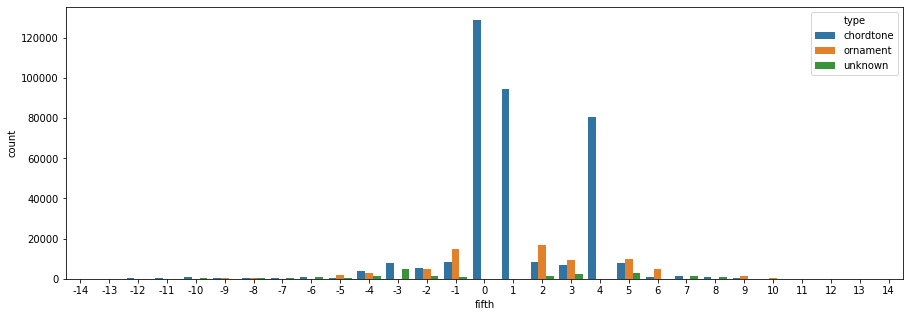

In [19]:
maj_df = wiki_harms[wiki_harms['label']=='M']
plt.figure(figsize=(15,5))
sns.countplot(x='fifth', hue='type', data=maj_df)

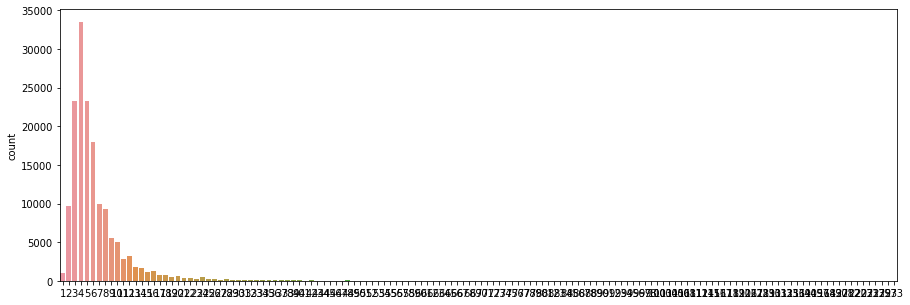

In [20]:
sizes = wiki_harms.groupby(['chordid', 'label']).size()
plt.figure(figsize=(15,5))
sns.countplot(sizes)

In [21]:
type_counts = sizes.groupby('label').size().sort_values(ascending=False)
print(type_counts)
wiki_harmtypes = type_counts.index.tolist()
major = wiki_harmtypes.index('M')
print("major =", major)

label
M      69651
m      33961
Mm7    27810
o       8830
o7      5850
mm7     4749
%7      3882
MM7     1600
+        583
mM7       80
+7        50
dtype: int64
major = 0


In [22]:
wiki_harms['numlabel'] = wiki_harms['label'].map(wiki_harmtypes.index)

In [345]:
wiki_harms

,chordid,label,fifth,type,numlabel
0,0,m,0,chordtone,1
1,0,m,0,chordtone,1
2,0,m,0,chordtone,1
3,1,M,4,chordtone,0
4,2,m,-3,chordtone,1
...,...,...,...,...,...
1031223,157351,M,0,chordtone,0
1031224,157352,Mm7,4,chordtone,2
1031225,157352,Mm7,0,unknown,2
1031226,157352,Mm7,0,unknown,2


In [24]:
wiki_chords = [{'label': label, 'notes': list(zip(grp.fifth, grp.type))}
              for (_, label), grp in tqdm.tqdm(wiki_harms.groupby(['chordid', 'numlabel']))]

100%|██████████| 157046/157046 [01:06<00:00, 2359.49it/s]


In [25]:
wiki_obs = annot_data_obs(wiki_chords)
wiki_obs

{'notes': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'c': tensor([1, 0, 1,  ..., 4, 0, 2]),
 'n': tensor([2., 0., 0.,  ..., 3., 6., 3.])}

In [29]:
wiki_obs['notes'][wiki_obs['c'] == major].reshape(-1, npcs).sum(dim=0)

tensor([1.8000e+01, 6.5000e+01, 2.8900e+02, 3.3700e+02, 1.0650e+03, 9.7400e+02,
        7.4300e+02, 1.0970e+03, 2.0840e+03, 2.6190e+03, 8.1080e+03, 1.2694e+04,
        1.1452e+04, 2.3844e+04, 1.2892e+05, 9.4487e+04, 2.6228e+04, 1.8131e+04,
        8.0386e+04, 2.0712e+04, 5.5670e+03, 2.7920e+03, 1.9690e+03, 1.7800e+03,
        5.3600e+02, 2.4700e+02, 2.0200e+02, 1.1900e+02, 2.5000e+01])

In [30]:
nharms = len(wiki_harmtypes)
nchords = len(wiki_chords)
print(nharms, "chord types")
print(nchords, "chords")

11 chord types
157046 chords


In [ ]:
def load_dataset(filename):
    print("loading dataset...")
    df = utils.load_csv(filename)
    type_counts = sizes.groupby('label').size().sort_values(ascending=False)
    harmtypes = type_counts.index.tolist()
    df['numlabel'] = df.label.map(harmtypes.index)
    print('extracting chords...')
    chords = [{'label': label, 'notes': list(zip(grp.fifth, grp.type))}
              for (_, label), grp in tqdm.tqdm(wiki_harms.groupby(['chordid', 'numlabel']))]
    print('converting chords to tensors')
    obs = annot_data_obs(chords)
    nharms = len(harmtypes)
    print(nharms, "chord types")
    print(len(chords), "chords")
    #nchords = len(chords)
    return df, obs, nharms

tensor([3.5940e+05, 1.7019e+05, 8.1621e+04, 3.2835e+04, 2.1067e+04, 1.4032e+04,
        1.1121e+04, 4.7810e+03, 3.0240e+03, 2.7800e+02, 1.4000e+02],
       dtype=torch.float64)

In [377]:
def get_init_params(df, nharms, npcs):
    init = dict()
    
    init['harmonies'] = torch.tensor(df.groupby('numlabel').size().sort_values()) + 0.5

    init['chordtones'] = torch.zeros([nharms,npcs]) + 0.5
    for (numlabel, fifth), grp in df[df.type=='chordtone'].groupby(['numlabel','fifth']):
        init['chordtones'][numlabel, utils.fifth_to_index(fifth)] += grp.fifth.count()

    init['ornaments'] = torch.zeros([nharms,npcs]) + 0.5
    for (numlabel, fifth), grp in df[df.type=='ornament'].groupby(['numlabel','fifth']):
        init['ornaments'][numlabel, utils.fifth_to_index(fifth)] += grp.fifth.count()
    
    init['is_ct'] = torch.tensor([sum(df[df.numlabel==l].type=='chordtone') for l in range(nharms)])
    #torch.tensor(sum(df.type=='chordtone') + 1)
    init['is_or'] = torch.tensor([sum(df[df.numlabel==l].type=='ornament') for l in range(nharms)])
    #torch.tensor(sum(df.type=='ornament') + 1)
    
    chord_sizes = df.groupby('chordid').size()-1
    init['sum_chords'] = torch.tensor(sum(chord_sizes) + 3)
    init['n_chords'] = torch.tensor(len(chord_sizes) + 1)
    return init

In [378]:
wiki_init = get_init_params(wiki_harms, nharms, npcs)
wiki_init

{'harmonies': tensor([3.2150e+02, 7.8650e+02, 3.4665e+03, 1.0886e+04, 2.5728e+04, 3.0752e+04,
         4.3632e+04, 4.8494e+04, 2.0609e+05, 2.1335e+05, 4.4750e+05]),
 'chordtones': tensor([[8.5000e+00, 3.8500e+01, 1.8950e+02, 2.4050e+02, 6.8950e+02, 2.0550e+02,
          2.7850e+02, 6.0650e+02, 1.0845e+03, 5.3950e+02, 3.7945e+03, 7.8845e+03,
          5.2185e+03, 8.1735e+03, 1.2893e+05, 9.4488e+04, 8.1785e+03, 6.6905e+03,
          8.0386e+04, 7.9735e+03, 7.0150e+02, 1.3215e+03, 1.0215e+03, 3.4650e+02,
          1.2250e+02, 1.4350e+02, 1.1050e+02, 4.8500e+01, 5.0000e-01],
         [9.5000e+00, 4.5000e+00, 1.3500e+01, 5.4500e+01, 4.3500e+01, 6.0500e+01,
          1.0350e+02, 3.6850e+02, 1.2375e+03, 4.0850e+02, 1.4785e+03, 4.6332e+04,
          4.3775e+03, 2.3375e+03, 5.8970e+04, 4.3920e+04, 3.7135e+03, 2.7525e+03,
          2.3385e+03, 9.6150e+02, 3.4050e+02, 1.7550e+02, 9.6500e+01, 5.0500e+01,
          1.2500e+01, 8.5000e+00, 1.2500e+01, 2.1500e+01, 2.5000e+00],
         [3.5000e+00, 1

## Inference

100%|██████████| 5000/5000 [04:04<00:00, 20.42it/s]


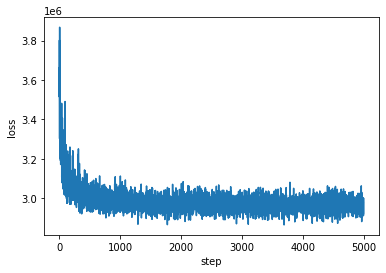

In [379]:
# optimize the parameters of the guide
pyro.clear_param_store()
svi = pyro.infer.SVI(model=chord_model,
                     guide=chord_guide,
                     optim=pyro.optim.Adam({"lr": 0.01, "betas": (0.95, 0.999)}),
                     #optim=pyro.optim.Adadelta({"lr": 1.0, "rho": 0.9}),
                     #optim=pyro.optim.SGD({"lr": 0.00005, "momentum": 0.9, "nesterov": True}),
                     loss=pyro.infer.Trace_ELBO())

# configuration values
nsteps = 5_000
subsamples = 10_000 # 10_000 is pretty fast (~15 it/s), but lower values are fine wrt. variance

# set up collection of intermediate values for the loss and some of the parameters
losses = np.zeros(nsteps)
param_values = {name:np.zeros(nsteps) for name in ['alpha_rate_notes', 'beta_rate_notes']}#, 'alpha_p_ict', 'beta_p_ict']}
root_values = np.zeros((nsteps,nharms))

# run the optimization
for i in tqdm.trange(nsteps):
    losses[i] = svi.step(npcs, nharms, wiki_obs, subsamples, init=wiki_init)
    ps = pyro.get_param_store()
    root_values[i] = ps.get_param('params_p_chordtones').detach()[:,fifth_range]
    for (name, value) in ps.items():
        if name in param_values:
            param_values[name][i] = value.item()

# plot the loss
plt.figure()
plt.plot(losses)
plt.xlabel("step")
plt.ylabel("loss")
plt.show()

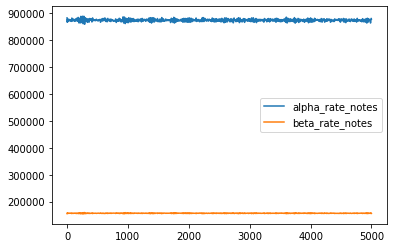

In [381]:
df = pd.DataFrame(param_values)
df.plot()

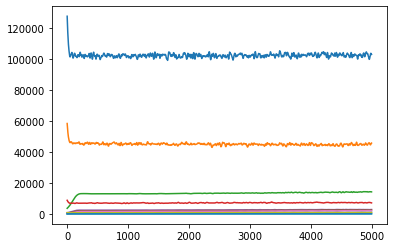

In [382]:
plt.plot(root_values)

In [383]:
# show optimized parameters:
for (name, value) in pyro.get_param_store().items():
    print(name, ":\t", value)

params_p_harmony :	 tensor([216.1268, 104.9995,  86.4188,  28.2516,  17.9162,  15.2710,  12.0722,
          4.9449,   2.2363,   0.4907,   0.3584], grad_fn=<AddBackward0>)
params_p_chordtones :	 tensor([[1.2579e+01, 5.0569e+01, 2.1820e+02, 2.6385e+02, 8.8917e+02, 1.9328e+02,
         3.6511e+02, 8.7771e+02, 1.6430e+03, 4.9436e+02, 3.7944e+03, 9.8516e+03,
         4.6829e+03, 6.8891e+03, 1.0299e+05, 7.4672e+04, 6.7830e+03, 6.1323e+03,
         6.3927e+04, 7.4456e+03, 5.7888e+02, 2.2044e+03, 1.5405e+03, 3.0019e+02,
         1.1846e+02, 1.8158e+02, 1.6228e+02, 5.6515e+01, 1.2583e+00],
        [8.6775e+00, 7.5883e+00, 1.3371e+01, 8.3294e+01, 4.4108e+01, 6.5718e+01,
         8.2610e+01, 5.7026e+02, 1.8201e+03, 3.2742e+02, 1.3320e+03, 3.5689e+04,
         4.0880e+03, 1.8110e+03, 4.5769e+04, 3.3129e+04, 3.0087e+03, 2.5387e+03,
         3.1507e+03, 8.0669e+02, 2.5210e+02, 3.6221e+02, 2.6240e+02, 5.9323e+01,
         1.1413e+01, 1.3906e+01, 1.9674e+01, 2.1454e+01, 2.4806e+00],
        [3.0465e+0

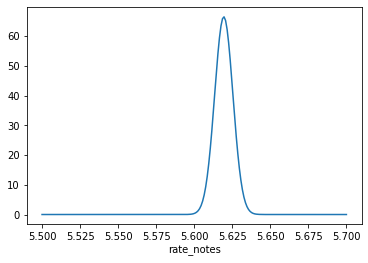

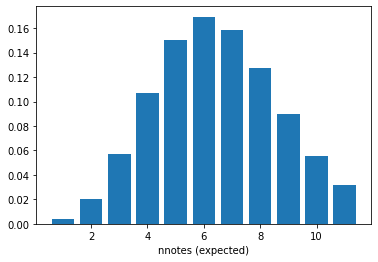

In [456]:
# posterior of 'rate_notes'
a = pyro.get_param_store().get_param("alpha_rate_notes").item()
b = pyro.get_param_store().get_param("beta_rate_notes").item()
x = np.linspace(5.5,5.7,200)
y = stats.gamma.pdf(x, a, scale=1/b)
plt.plot(x,y)
plt.xlabel('rate_notes')
plt.show()
xrate = torch.linspace(0,10,11)
yrate = stats.nbinom.pmf(xrate, a, 1/(1+1/b))
plt.bar(xrate+1, yrate)
plt.xlabel('nnotes (expected)')
plt.show()

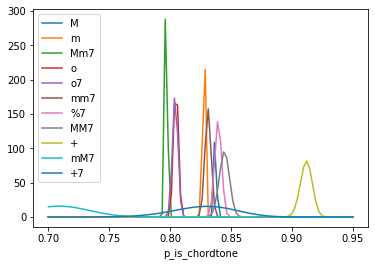

In [463]:
# posterior of 'p_is_chordtone'
post_p_ict_alpha = pyro.get_param_store().get_param("alpha_p_ict").detach()
post_p_ict_beta  = pyro.get_param_store().get_param("beta_p_ict").detach()
x = torch.linspace(0.7,0.95,100)
y = np.array([stats.beta.pdf(x, a, b) for a, b in zip(post_p_ict_alpha, post_p_ict_beta)]).transpose()
plt.plot(x,y)
plt.xlabel("p_is_chordtone")
plt.legend(wiki_harmtypes)
plt.show()

In [326]:
post_p_harmony = pyro.get_param_store().get_param("params_p_harmony").detach()

In [327]:
def plot_chord_type_dist(params, labels):
    plt.figure(figsize=(6,9))
    plt.barh(np.arange(len(params)), params, tick_label=labels)
    plt.show()

tensor([202.2735,  98.1540,  79.8187,  25.2093,  17.2527,  13.8951,  11.2830,
          5.1051,   2.1069,   0.4482,   0.2716])
['M', 'm', 'Mm7', 'o', 'o7', 'mm7', '%7', 'MM7', '+', 'mM7', '+7']


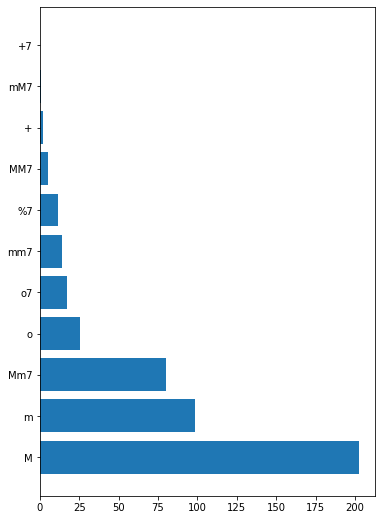

In [328]:
#post_p_harmony = pyro.get_param_store().get_param("params_p_harmony").detach().numpy()
print(post_p_harmony)
print(wiki_harmtypes)

plot_chord_type_dist(post_p_harmony, wiki_harmtypes)

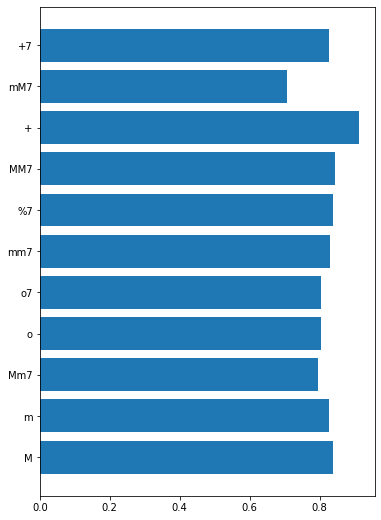

In [380]:
alpha_p_ict = pyro.get_param_store().get_param('alpha_p_ict').detach()
beta_p_ict = pyro.get_param_store().get_param('beta_p_ict').detach()
plot_chord_type_dist(alpha_p_ict / (alpha_p_ict + beta_p_ict), wiki_harmtypes)

In [329]:
def plot_chord(chordtones, ornaments, name):
    #cs = np.roll(chordtones, fifth_range)
    #os = np.roll(ornaments, fifth_range)
    labels = np.arange(-fifth_range, fifth_range+1)
    x = np.arange(npcs)
    width = 0.4
    fig, ax = plt.subplots(figsize=(15,5))
    plt.bar(x - width/2, chordtones, width, label='chord tones')
    plt.bar(x + width/2, ornaments, width, label='ornaments')
    ax.set_title(name)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
#     fig, ax = plt.subplots(2, 1, figsize=(12,9))
#     ax[0].bar(np.arange(npcs), cs, tick_label=labels)
#     ax[0].set_title("{} chord tones".format(name))
#     ax[1].bar(np.arange(npcs), os, tick_label=labels)
#     ax[1].set_title("{} ornaments".format(name))
    plt.show()

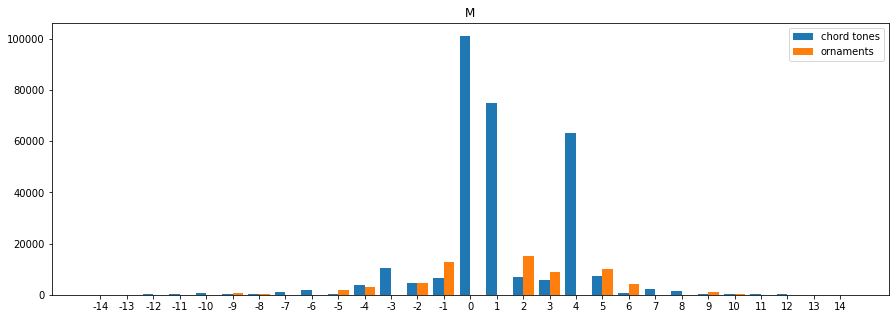

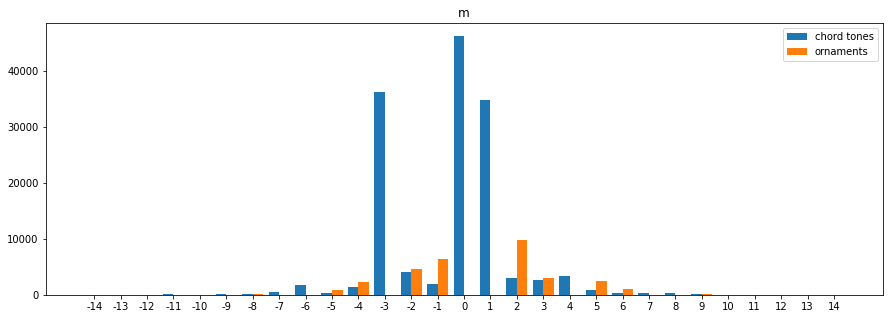

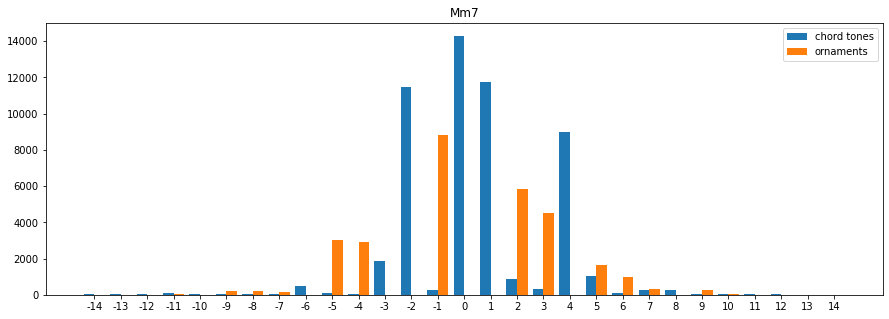

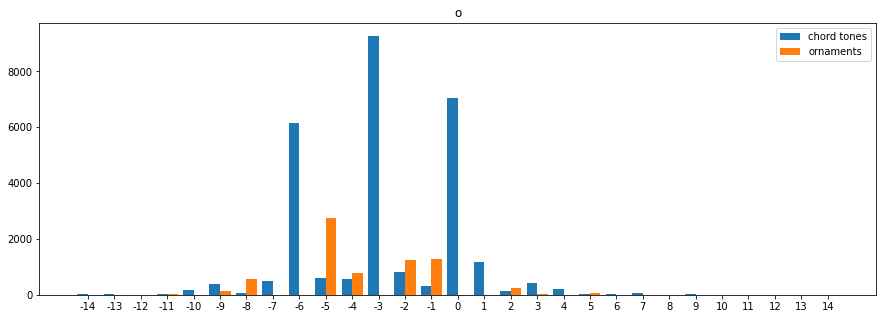

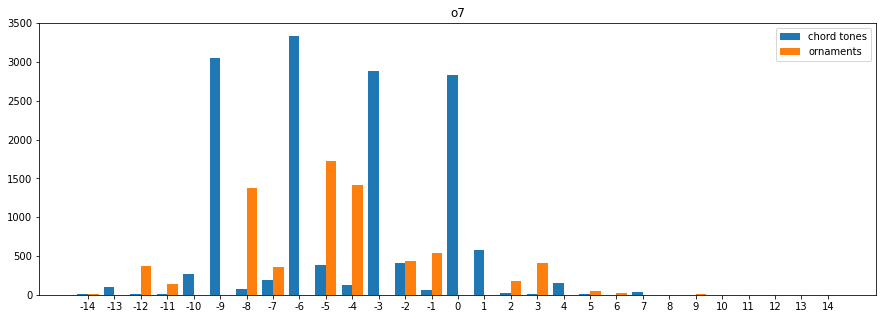

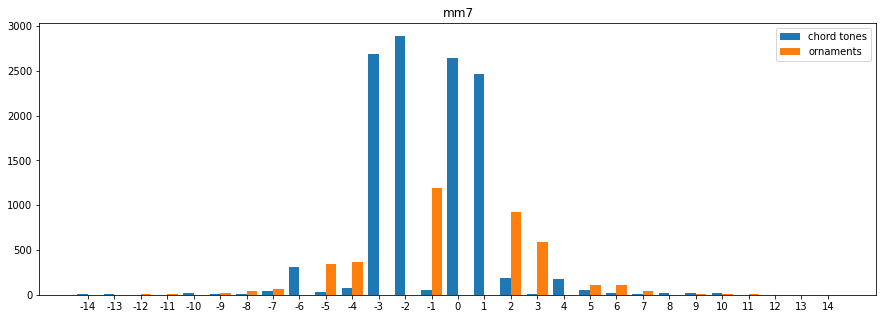

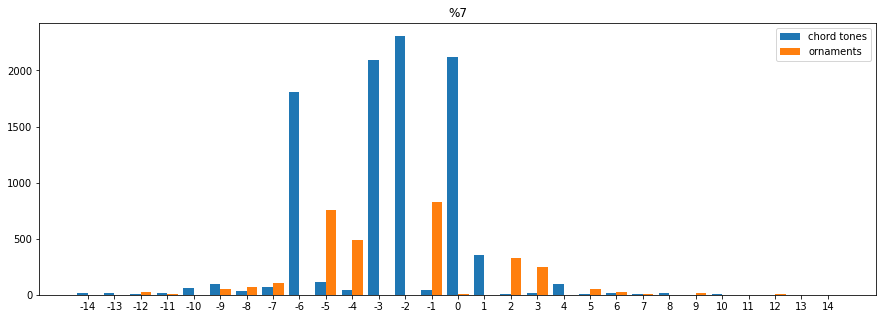

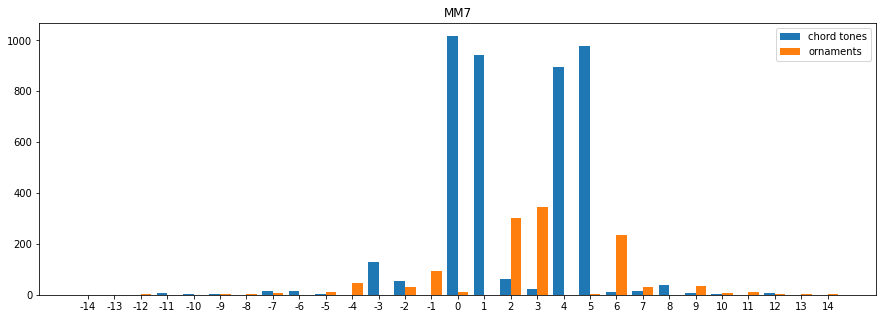

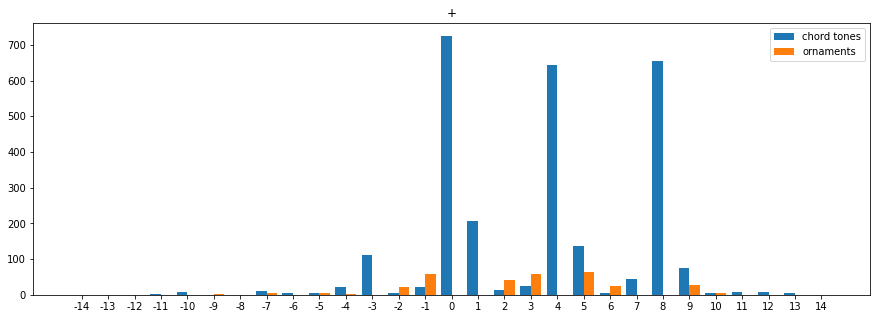

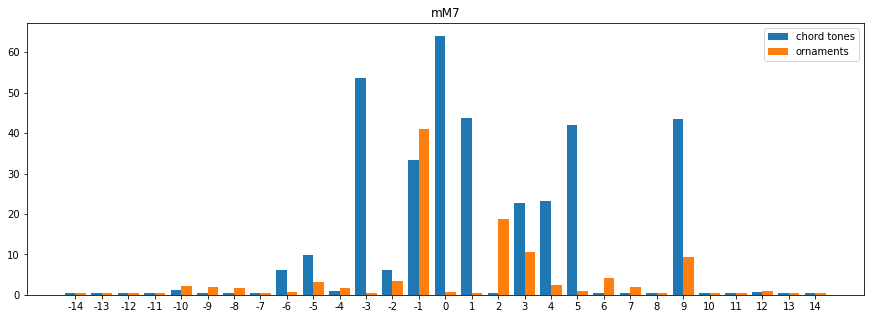

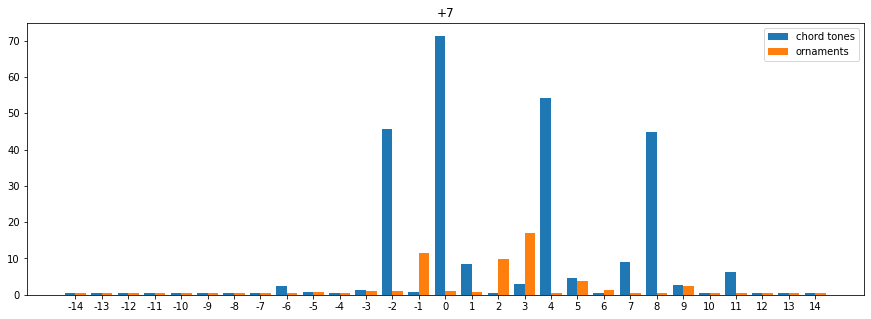

In [330]:
post_chordtones = pyro.get_param_store().get_param("params_p_chordtones").detach()
post_ornaments = pyro.get_param_store().get_param("params_p_ornaments").detach()
for i, name in enumerate(wiki_harmtypes):
    utils.plot_profile(post_chordtones[i], post_ornaments[i], name)
    utils.play_chord(post_chordtones[i])

In [69]:
pyro.get_param_store().save('params_generic.pt')

# Prediction

once the posterior distribution of the chord types are known, we can use them to predict the chord type of a (new) set of notes.

$$
p(h \mid n', D) = \dfrac{p(n' \mid h, D) p(h \mid D)}{p(n' \mid D)}
$$

$p(h \mid D)$ is represented in the (approximate) posterior by the Dirichlet distribution $p(\chi \mid D)$.
It can be expressed as
$$p(h \mid D) = \int p(h \mid \chi) p(\chi \mid D) d\chi,$$
where $\chi$ is the parameter vector for the categorical Distribution of $h$.

$p(n' \mid h, D)$ is represented in the posterior as a combination of the dirichlet distributions of chord tones $p(\phi_{ct}^{(h)} \mid D)$ and ornaments $p(\phi_{or}^{(h)} \mid D)$ and the beta distribution of the chord-tone probability $p(\theta \mid D)$.
$$
  p(n' \mid h, D) = \int \int \int p(n' \mid \phi_{ct}^{(h)}, \phi_{or}^{(h)}, \theta)
    p(\phi_{ct}^{(h)} \mid D) p(\phi_{or}^{(h)} \mid D) p(\theta \mid D)\ d \phi_{ct}^{(h)} d \phi_{or}^{(h)} d \theta,
$$
where
$$
  p(n' \mid  \phi_{ct}^{(h)}, \phi_{or}^{(h)}, \theta) = Multinomial(|n'|, \nu),
$$
with $\nu$ as defined above.

Since this integral is a bit tricky to calculate (\*ahem\*) we write another model and guide to numerically compute the distribution $p(h \mid n', D)$

In [31]:
def chord_model_pred(npcs, nharmonies, obs_chords, pobserve=0.5):
    # parameters priors:
    # distribution of the harmonies
    p_harmony = pyro.sample('p_harmony', Dirichlet(post_p_harmony))
    # distribution of ornament probability
    p_is_chordtone = pyro.sample('p_is_chordtone', Beta(post_p_ict_alpha, post_p_ict_beta))
    # distribution of notes in the harmonies
    with pyro.plate('harmonies', nharmonies) as ind:
        # distribution of notes per note type
        p_chordtones = pyro.sample('p_chordtones', Dirichlet(post_chordtones))
        p_ornaments  = pyro.sample('p_ornaments', Dirichlet(post_ornaments))
        #print(p_chordtones.shape)
        # we build a big categorical out of the chordtones and ornaments,
        # including notes of unknown type (marginalizing over the categories)
        p_ct = p_is_chordtone       * p_chordtones
        p_or = (1 - p_is_chordtone) * p_ornaments
        p_unobserved = p_ct + p_or
        p_tones = torch.cat([pobserve * p_ct, pobserve * p_or, (1-pobserve) * p_unobserved], dim=1)
    
    # sample the chord
    nchords = obs_chords.shape[0]
    with pyro.plate('chords', nchords):
        h = pyro.sample('h', Categorical(p_harmony))
        chord = pyro.sample('chord', Multinomial(1, p_tones[h], validate_args=False), obs=obs_chords)
    return h, chord

In [32]:
chord_model_pred(npcs, nharms, chord_tensor(wiki_chords[0]['notes']).reshape(1,-1))

(tensor([1]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]))

In [33]:
@pyro.infer.config_enumerate
def chord_guide_pred(npcs, nharmonies, obs_chords, pobserve=0.5):
    # sample according to known posterior
    pyro.sample('p_harmony', Dirichlet(post_p_harmony))
    pyro.sample('p_is_chordtone', Beta(post_p_ict_alpha, post_p_ict_beta))
    with pyro.plate('harmonies', nharmonies) as ind:
        pyro.sample('p_chordtones', Dirichlet(post_chordtones))
        pyro.sample('p_ornaments', Dirichlet(post_ornaments))
    
    # estimate the predictive
    nchords = obs_chords.shape[0]
    p_harmony = pyro.param('params_h', torch.ones(nchords,nharmonies) / nharmonies, constraint=constraints.simplex)
    #nnotes = obs_chord.sum().int()
    with pyro.plate("chords", nchords):
        h = pyro.sample('h', Categorical(p_harmony))

In [34]:
def predict(npcs, nharmonies, chords, pobserve=0.5, iterations=100, plot_loss=True):
    obs_chord = torch.cat([chord_tensor(notes).reshape(1,-1) for notes in chords], dim=0)
    pyro.clear_param_store()
    svi = pyro.infer.SVI(model=chord_model_pred,
                         guide=chord_guide_pred,
                         optim=pyro.optim.Adam({"lr": 0.005, "betas": (0.95, 0.999)}),
                         loss=pyro.infer.TraceEnum_ELBO(max_plate_nesting=1))

    losses = []

    for i in tqdm.trange(iterations):
        losses.append(svi.step(npcs, nharms, obs_chord, pobserve))
        
    if plot_loss:
        plt.plot(losses)
        plt.xlabel("step")
        plt.ylabel("loss")
        plt.show()
    
    return pyro.get_param_store().get_param('params_h').detach()

We can run predictive inference on some of our data.
Note that this is not a proper evaluation since we use the same data for training and prediction.
Furthermore, we can't expect our predictions to be very good, since the data only contains the melodic part, which makes it very difficult to infer the correct harmony.

100%|██████████| 1500/1500 [01:56<00:00, 12.90it/s]


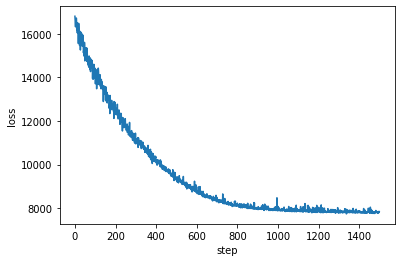

In [35]:
pred = predict(npcs, nharms, [c['notes'] for c in wiki_chords[0:1000]], iterations=1500)

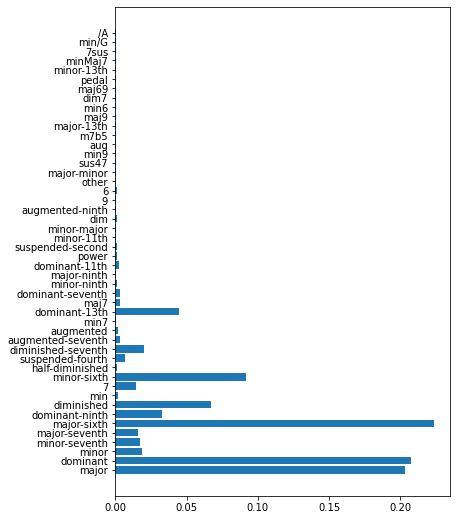

In [36]:
plot_chord_type_dist(pred[0], wiki_harmtypes)

In [37]:
wiki_chords[0]['notes']

[(3, 'chordtone')]

In [38]:
wiki_harmtypes[wiki_chords[0]['label']]

'dominant-13th'

In [39]:
wiki_harmtypes[pred[0].argmax().item()]

'major-sixth'

In [92]:
labels = np.array([wiki_harmtypes[c['label']] for c in wiki_chords[0:1000]])
predictions = np.array([wiki_harmtypes[p] for p in pred.argmax(dim=1)])
sum(l != p for (l,p) in zip(labels, predictions))

438

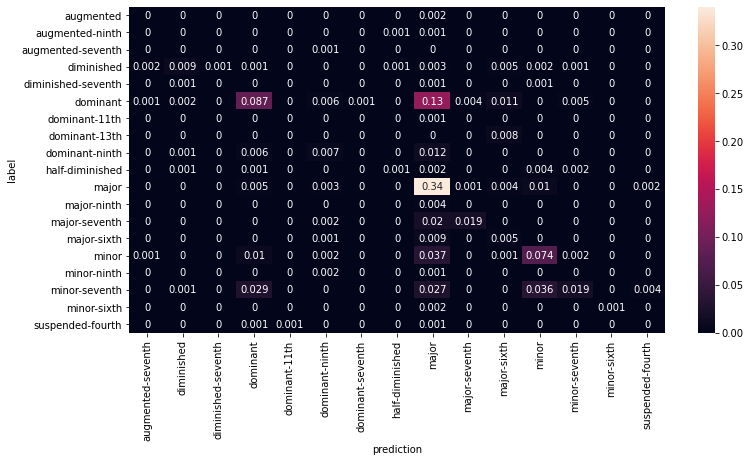

In [41]:
conf = pd.crosstab(labels, predictions, rownames=['label'], colnames=['prediction'], normalize=True)
plt.figure(figsize=(12,6))
sns.heatmap(conf, annot=True)